# Optimizing Retrieval Augmentation with Dynamic Top-K Tuning for Efficient Question Answering

In this notebook, we will train a cross-encoder to intelligently predict retrieval top-k, enhancing the precision and resource efficiency of question-answering systems specifically in RAG settings.

Here's a more streamlined version of the process: <br>

**Training**
1. We segment each document into chunks and index these in a vector database.
2. Iterating from k = 1 to 10, we retrieve the top k passages for each iteration and prompt the language model to generate answers based on a given question.
3. Utilizing a custom RankCorrectnessEvaluator, we rank the ten candidate answers in relation to the reference answer and the query.
4. We compile a training dataset comprising the query, document, and the optimal top k value for each query-document pair derived from the ranking step.
5. This dataset is used to train a cross encoder, which predicts the top k value by learning from the query and document context.

**Inference**
1. We begin by dividing the document into chunks and indexing these in the vector database.
2. For a given document and query, we predict the top k value and input this into the retriever.
3. The large language model receives the top k passages as context to generate the answer.
4. We assess the effectiveness of static versus dynamic retrieval strategies by employing evaluation metrics such as CorrectnessEvaluator, SimilarityEvaluator, and TokenCounter.

![top-k-retrieval-cross-encoder-qasper-rag-weaviate.png](../assets/img/top-k-retrieval-cross-encoder-qasper-rag-weaviate.png)

In [ ]:
!pip install llama-index datasets sentence-transformers openai tiktoken python-dotenv

In [ ]:
!pip install --pre "weaviate-client==4.*"

In [ ]:
# Helps asyncio run within Jupyter
import nest_asyncio

nest_asyncio.apply()

In [ ]:
import os
import re
import pickle
import openai
import tiktoken
import random
import ast
import time
import pandas as pd
import weaviate
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from llama_index.vector_stores import WeaviateVectorStore
from IPython.display import Markdown, display
from llama_index import QueryBundle
from llama_index.retrievers import BaseRetriever, VectorIndexRetriever
from llama_index import Document
from typing import Any, List, Optional
from tqdm.auto import tqdm
from llama_index import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    ServiceContext,
    Response,
    set_global_service_context
)
from llama_index.storage.storage_context import StorageContext
from llama_index.vector_stores import VectorStoreQuery
from llama_index.schema import NodeWithScore
from llama_index.embeddings import OpenAIEmbedding
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.llms import OpenAI
from llama_index.prompts import PromptTemplate
from llama_index.llms import ChatMessage, MessageRole
from llama_index.prompts import ChatPromptTemplate
from llama_index import Document
from llama_index.evaluation import SemanticSimilarityEvaluator
from llama_index.embeddings import SimilarityMode
from llama_index.evaluation import CorrectnessEvaluator
from llama_index.evaluation.eval_utils import get_responses, get_results_df
from llama_index.callbacks import CallbackManager, TokenCountingHandler
from dotenv import load_dotenv

In [ ]:
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.getenv('OPENAI_API_KEY')

## Data Preparation

In [ ]:
# Download QASPER dataset from HuggingFace https://huggingface.co/datasets/allenai/qasper
dataset = load_dataset("allenai/qasper")

# Split the dataset into train, validation, and test splits
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

random.seed(42)  # Set a random seed for reproducibility

# Randomly sample 800 rows from the training split
train_sampled_indices = random.sample(range(len(train_dataset)), 800)
train_samples = [train_dataset[i] for i in train_sampled_indices]


# Randomly sample 100 rows from the test split
test_sampled_indices = random.sample(range(len(test_dataset)), 80)
test_samples = [test_dataset[i] for i in test_sampled_indices]

Generating train split:   0%|          | 0/888 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/281 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/416 [00:00<?, ? examples/s]

In [ ]:
# Get full text paper data , questions on the paper from training samples of QASPER to generate training dataset for cross-encoder finetuning

# Utility function to get full-text of the research papers from the dataset
def get_full_text(sample: dict) -> str:
    """
    :param dict sample: the row sample from QASPER
    """
    title = sample["title"]
    abstract = sample["abstract"]
    sections_list = sample["full_text"]["section_name"]
    paragraph_list = sample["full_text"]["paragraphs"]
    combined_sections_with_paras = ""
    if len(sections_list) == len(paragraph_list):
        combined_sections_with_paras += title + "\t"
        combined_sections_with_paras += abstract + "\t"
        for index in range(0, len(sections_list)):
            combined_sections_with_paras += str(sections_list[index]) + "\t"
            combined_sections_with_paras += "".join(paragraph_list[index])
        return combined_sections_with_paras

    else:
        print("Not the same number of sections as paragraphs list")

# utility function to extract list of questions from the dataset
def get_questions(sample: dict) -> List[str]:
    """
    :param dict sample: the row sample from QASPER
    """
    questions_list = sample["qas"]["question"]
    return questions_list

# Utility function to extract answers from the dataset
def get_answers(sample: dict) -> List[str]:
    """
    :param dict sample: the row sample from the train split of QASPER
    """
    final_answers_list = []
    answers = sample["qas"]["answers"]
    for answer in answers:
        local_answer = ""
        types_of_answers = answer["answer"][0]
        if types_of_answers["unanswerable"] == False:
            if types_of_answers["free_form_answer"] != "":
                local_answer = types_of_answers["free_form_answer"]
            else:
                local_answer = "Unacceptable"
        else:
            local_answer = "Unacceptable"

        final_answers_list.append(local_answer)

    return final_answers_list


doc_qa_dict_list = []
eval_doc_qa_answer_list = []

for train_sample in train_samples:
    full_text = get_full_text(train_sample)
    questions_list = get_questions(train_sample)
    answers_list = get_answers(train_sample)
    local_dict = {
        "paper": full_text,
        "questions": questions_list,
        "answers": answers_list,
    }
    doc_qa_dict_list.append(local_dict)

for test_sample in test_samples:
    full_text = get_full_text(test_sample)
    questions_list = get_questions(test_sample)
    answers_list = get_answers(test_sample)
    local_dict = {
        "paper": full_text,
        "questions": questions_list,
        "answers": answers_list,
    }
    eval_doc_qa_answer_list.append(local_dict)

In [ ]:
len(doc_qa_dict_list), len(eval_doc_qa_answer_list)

(800, 80)

In [ ]:
# Save training data as a csv
df_train = pd.DataFrame(doc_qa_dict_list)
df_train.to_csv("train.csv")

# Save eval data as a csv
df_test = pd.DataFrame(eval_doc_qa_answer_list)
df_test.to_csv("test.csv")

## Setup Weaviate

You can setup Weaviate vector database by creating an account and by following the instructions mentioned <a href="https://weaviate.io/developers/weaviate/installation/weaviate-cloud-services">here</a> to create and query the index.

In [ ]:
# cloud
client = weaviate.Client(
    url="https://....weaviate.network")
client.schema.get()

In [ ]:
weaviate_vector_store = WeaviateVectorStore(
    weaviate_client=client, index_name="LlamaIndex"
)

## Retrieval Loop - Create Training Dataset

I went through LlamaIndex's documentation and couldn't find an evaluator that can rank multiples responses. The PairwiseComparisonEvaluator essentially compares 2 responses wrt to the reference answer and the query but in this experiment, we have multiple responses. Hence, I created RankCorrectnessEvaluator which ranks multiple responses associated with the respective k value during retrieval. You can look at the prompt for more details.

In [ ]:
from typing import Any, Optional, Sequence, Union, Dict

from llama_index.evaluation.base import BaseEvaluator, EvaluationResult
from llama_index.indices.service_context import ServiceContext
from llama_index.prompts import (
    BasePromptTemplate,
    ChatMessage,
    ChatPromptTemplate,
    MessageRole,
    PromptTemplate,
)
from llama_index.prompts.mixin import PromptDictType

RANKING_SYSTEM_TEMPLATE = """
You are an expert evaluation system for a question answering chatbot.

You are given the following information:
- a user query,
- a reference answer, and
- a list of generated answers, each associated with a different 'k' value.

Your job is to rank the generated answers in order of correctness and relevance to the user query and the reference answer, from best to worst.

Correctness should be judged based on:
- The number of overlapping tokens with the reference answer.
- The absence of incorrect information not present in the reference answer.
- The lack of unnecessary or irrelevant tokens that do not contribute to answering the query.

Please provide a ranked list of the 'k' values associated with the generated answers, starting with the 'k' value of the best answer and ending with the 'k' value of the worst answer.
Do not return answers in any other format.

You are given the following information:
- a user query,
- a reference answer, and
- generated answers.

User Query
query

Reference Answer
reference_answer

Generated Answers
k_1: answer_1
k_2: answer_2
...
k_10: answer_10

Based on the information provided and the criteria for correctness, rank the 'k' values from best to worst.
For example:
["k_7", "k_2", "k_9", ..., "k_3"]
"""

DEFAULT_USER_TEMPLATE = """
## User Query
{query}

## Reference Answer
{reference_answer}

## Generated Answers
{generated_answers}
"""

DEFAULT_EVAL_TEMPLATE = ChatPromptTemplate(
    message_templates=[
        ChatMessage(role=MessageRole.SYSTEM, content=RANKING_SYSTEM_TEMPLATE),
        ChatMessage(role=MessageRole.USER, content=DEFAULT_USER_TEMPLATE),
    ]
)

class RankCorrectnessEvaluator(BaseEvaluator):
    """Rank correctness evaluator.

    Evaluates and ranks the correctness of multiple generated answers for a question answering system.
    This evaluator depends on `reference` answer to be provided, in addition to the
    query string and multiple response strings.

    It outputs a ranked list of 'k' values associated with the generated answers.

    Args:
        service_context (Optional[ServiceContext]): Service context.
        eval_template (Optional[Union[BasePromptTemplate, str]]):
            Template for the evaluation prompt.
    """

    def __init__(
        self,
        service_context: Optional[ServiceContext] = None,
        eval_template: Optional[Union[BasePromptTemplate, str]] = None,
    ) -> None:
        self._service_context = service_context or ServiceContext.from_defaults()

        self._eval_template: BasePromptTemplate
        if isinstance(eval_template, str):
            self._eval_template = PromptTemplate(eval_template)
        else:
            self._eval_template = eval_template or DEFAULT_EVAL_TEMPLATE

    def _get_prompts(self) -> PromptDictType:
        """Get prompts."""
        return {
            "eval_template": self._eval_template,
        }

    def _update_prompts(self, prompts: PromptDictType) -> None:
        """Update prompts."""
        if "eval_template" in prompts:
            self._eval_template = prompts["eval_template"]

    async def aevaluate(
        self,
        query: Optional[str] = None,
        responses: Optional[Dict[str, str]] = None,
        reference: Optional[str] = None,
        **kwargs: Any,
    ) -> EvaluationResult:
        del kwargs  # Unused

        if query is None or responses is None or reference is None:
            raise ValueError("query, responses, and reference must be provided")

        generated_answers_str = "\n".join(
            [f"{k}: {answer}" for k, answer in responses.items()]
        )

        eval_response = await self._service_context.llm_predictor.apredict(
            prompt=self._eval_template,
            query=query,
            generated_answers=generated_answers_str,
            reference_answer=reference,
        )

        return EvaluationResult(
            query=query,
            response=eval_response
        )

In [ ]:
train_evaluator_service_context = ServiceContext.from_defaults(llm=OpenAI("gpt-4"))
train_evaluator = RankCorrectnessEvaluator(service_context=train_evaluator_service_context)

In [ ]:
topk_training_dataset = []

Here, we are iterating from k=1 to 10 and storing all the responses in a dictionary with keys being the k value and value being the corresponding response. Next, we are sending these responses to the RankCorrectness Evaluator module to return the k value of the most relevant or correct response.

In [ ]:
for paper in tqdm(doc_qa_dict_list[:100]):
    try: ## safety against any openai error
        questions_list = paper["questions"]
        documents = [Document(text=paper["paper"])]
        reference_answers_list = paper["answers"]

        assert len(questions_list) == len(reference_answers_list)

        for question, reference_answer in zip(questions_list, reference_answers_list):
            responses = {}

            if reference_answer == "Unacceptable":
                continue

            for k_val in tqdm(range(1, 11)):

                service_context = ServiceContext.from_defaults(chunk_size=512)
                node_parser = service_context.node_parser
                nodes = node_parser.get_nodes_from_documents(documents)

                storage_context = StorageContext.from_defaults(vector_store=weaviate_vector_store)
                storage_context.docstore.add_documents(nodes)
                weaviate_vector_index = VectorStoreIndex(nodes, storage_context=storage_context)

                weaviate_vector_retriever = VectorIndexRetriever(index=weaviate_vector_index, similarity_top_k=k_val)
                query_engine = RetrieverQueryEngine.from_args(weaviate_vector_retriever)
                response = query_engine.query(question)

                responses["k_"+str(k_val)] = response.response

            # rankcorrectness evaluator
            result = await train_evaluator.aevaluate(
                query=question,
                responses=responses,
                reference=reference_answer,
            )
            try:
                result = result.response
                eval_response_list = ast.literal_eval(result)
                ranked_k_values = [int(k.split('_')[1]) for k in eval_response_list]
            except:
                try:
                    list_pattern = r'\["k_[0-9]+(?:", "k_[0-9]+)*"\]'
                    match = re.search(list_pattern, result.response)
                    if match:
                        list_str = match.group(0)
                        eval_response_list = ast.literal_eval(list_str)
                        ranked_k_values = [int(k.split('_')[1]) for k in eval_response_list]
                    else:
                        continue
                except:
                    continue

            # insert train dataset
            best_response_insertion = (paper['paper'], question, str(ranked_k_values[0]))
            topk_training_dataset.append(best_response_insertion)
            with open('training_tuples.pkl', 'wb') as file:
                pickle.dump(topk_training_dataset, file)
            time.sleep(10)
    except:
      pass

In [ ]:
with open('training_tuples.pkl', 'wb') as file:
    pickle.dump(topk_training_dataset, file)

with open('training_tuples.pkl', 'rb') as file:
    loaded_topk_training_dataset = pickle.load(file)

## Summarize Document

The cross encoder bert model max input length is 512 tokens. Hence, I am summarizing the long context paper using the below prompt. Then I am feeding the summarized document and the query alongwith the label i.e the ground truth top k value to the cross encoder for training.

In [ ]:
system_prompt = f"""Your task is to summarize the following document into a concise version of approximately 500 words.
Focus on capturing the main themes, essential points, and key arguments presented. Omit any extraneous details or repetitive
information to create a clear, coherent, and comprehensive summary that conveys the document's core message and intent.
Please ensure the summary is well-structured, with a clear beginning, middle, and end, and maintains the original
document's tone and perspective.
"""

def get_summary(document):
  res = openai.ChatCompletion.create(
      model="gpt-3.5-turbo-16k",
      messages=[
          {"role": "system", "content": system_prompt},
          {"role": "user", "content": document}
      ]
  )
  return res

In [ ]:
final_topk_training_dataset = []
for doc, qst, topk in tqdm(loaded_topk_training_dataset):
    response = get_summary(doc)
    summarized_doc = response["choices"][0]["message"]["content"]
    final_topk_training_dataset.append((summarized_doc, qst, topk))

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
len(final_topk_training_dataset)

48

In [ ]:
with open('final_training_tuples.pkl', 'wb') as file:
    pickle.dump(final_topk_training_dataset, file)

with open('final_training_tuples.pkl', 'rb') as file:
    loaded_final_topk_training_dataset = pickle.load(file)

## Train Cross Encoder

Now, we setup the training pipeline for the BERT-based cross-encoder model, designed to classify sequences into one of ten labels.

In [ ]:
!pip install accelerate -U
!pip install transformers[torch]

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

In [ ]:
class CEDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]) - 1)
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
texts = [(doc, qst) for doc, qst, topk in loaded_final_topk_training_dataset]
labels = [topk for doc, qst, topk in loaded_final_topk_training_dataset]
encodings = tokenizer.batch_encode_plus(texts, truncation=True, padding=True, max_length=512)
ce_dataset = CEDataset(encodings, labels)

In [ ]:
num_labels = 10
ce_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    per_device_train_batch_size=5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,
)

# Trainer
trainer = Trainer(
    model=ce_model,
    args=training_args,
    train_dataset=ce_dataset,
)

# Train
trainer.train()

Step,Training Loss
20,2.503900
40,2.199600
60,1.888100
80,1.650100
100,1.376800
120,1.165600
140,1.067600
160,0.939700
180,0.864200
200,0.814500


TrainOutput(global_step=200, training_loss=1.447016668319702, metrics={'train_runtime': 3785.2823, 'train_samples_per_second': 0.254, 'train_steps_per_second': 0.053, 'total_flos': 252604756131840.0, 'train_loss': 1.447016668319702, 'epoch': 20.0})

In [ ]:
# Save the model
ce_model.save_pretrained('./ce_model')
tokenizer.save_pretrained('./ce_model')

('./ce_model/tokenizer_config.json',
 './ce_model/special_tokens_map.json',
 './ce_model/vocab.txt',
 './ce_model/added_tokens.json')

## RAG Evaluation

In [ ]:
# Load Eval Data
df_test = pd.read_csv("./test.csv", index_col=0)

df_test["questions"] = df_test["questions"].apply(ast.literal_eval)
df_test["answers"] = df_test["answers"].apply(ast.literal_eval)
print(f"Number of papers in the test sample:- {len(df_test)}")

Number of papers in the test sample:- 80


### Baseline Evaluation k = 1

In [ ]:
gpt4 = OpenAI(temperature=0, model="gpt-4")
service_context_gpt4 = ServiceContext.from_defaults(llm=gpt4)

evaluator_similarity = SemanticSimilarityEvaluator()
evaluator_gpt4_correctness = CorrectnessEvaluator(service_context=service_context_gpt4)

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
token_counter = TokenCountingHandler(
    tokenizer=tiktoken.encoding_for_model("gpt-3.5-turbo").encode
)
callback_manager = CallbackManager([token_counter])
llm = OpenAI()
service_context = ServiceContext.from_defaults(
    llm=llm, callback_manager=callback_manager, embed_model="local"
)
set_global_service_context(service_context)

In [ ]:
similarity_scores_list = []
correctness_scores_list = []
total_llm_token_list = []
baseline_dict_list = []

for index, row in tqdm(df_test.iterrows()):
    documents = [Document(text=row["paper"])]
    query_list = row["questions"]
    reference_answers_list = row["answers"]
    number_of_accepted_queries = 0

    vector_index = VectorStoreIndex.from_documents(documents)
    query_engine = vector_index.as_query_engine(similarity_top_k=1)

    assert len(query_list) == len(reference_answers_list)
    similarity_local_score = 0
    correctness_local_score = 0
    total_llm_token_local = 0

    for index in range(0, len(query_list)):
        query = query_list[index]
        reference = reference_answers_list[index]

        if reference != "Unacceptable":
            number_of_accepted_queries += 1

            response = str(query_engine.query(query))

            baseline_dict = {
                "query": query,
                "response": response,
                "reference": reference,
            }
            baseline_dict_list.append(baseline_dict)

            similarity_eval_result = await evaluator_similarity.aevaluate(
                response=response, reference=reference
            )

            correctness_eval_result = await evaluator_gpt4_correctness.aevaluate(
                query=query,
                response=response,
                reference=reference,
            )

            similarity_score = similarity_eval_result.score
            correctness_score = correctness_eval_result.score
            total_llm_token = int(token_counter.total_llm_token_count)

            similarity_local_score += similarity_score
            correctness_local_score += correctness_score
            total_llm_token_local += total_llm_token

            token_counter.reset_counts()
        else:
            pass

    if number_of_accepted_queries > 0:
        avg_similarity_local_score = (
            similarity_local_score / number_of_accepted_queries
        )
        similarity_scores_list.append(avg_similarity_local_score)

        avg_correctness_local_score = (
            correctness_local_score / number_of_accepted_queries
        )
        correctness_scores_list.append(avg_correctness_local_score)

        avg_total_llm_token_local = (
            total_llm_token_local / number_of_accepted_queries
        )
        total_llm_token_list.append(avg_total_llm_token_local)


overall_similarity_average_score = sum(similarity_scores_list) / len(
    similarity_scores_list
)
overall_correctness_average_score = sum(correctness_scores_list) / len(
    correctness_scores_list
)
overall_total_llm_token_average = sum(total_llm_token_list) / len(
    total_llm_token_list
)
df_responses = pd.DataFrame(baseline_dict_list)
df_responses.to_csv("Baseline_Responses_k_1.csv")

In [ ]:
results_dict = {
    "name": ["Baseline k_1"],
    "similarity score": [overall_similarity_average_score],
    "correctness score": [overall_correctness_average_score],
    "average total llm token count": [overall_total_llm_token_average],
}
results_df = pd.DataFrame(results_dict)
display(results_df)

,name,similarity score,correctness score,average total llm token count
0,Baseline k_1,0.837208,2.761905,991.52381


### Baseline Evaluation k = 5

In [ ]:
similarity_scores_list = []
correctness_scores_list = []
total_llm_token_list = []
baseline_dict_list = []

for index, row in tqdm(df_test.iterrows()):
    documents = [Document(text=row["paper"])]
    query_list = row["questions"]
    reference_answers_list = row["answers"]
    number_of_accepted_queries = 0

    vector_index = VectorStoreIndex.from_documents(documents)
    query_engine = vector_index.as_query_engine(similarity_top_k=5)

    assert len(query_list) == len(reference_answers_list)
    similarity_local_score = 0
    correctness_local_score = 0
    total_llm_token_local = 0

    for index in range(0, len(query_list)):
        query = query_list[index]
        reference = reference_answers_list[index]

        if reference != "Unacceptable":
            number_of_accepted_queries += 1

            response = str(query_engine.query(query))

            baseline_dict = {
                "query": query,
                "response": response,
                "reference": reference,
            }
            baseline_dict_list.append(baseline_dict)

            similarity_eval_result = await evaluator_similarity.aevaluate(
                response=response, reference=reference
            )

            correctness_eval_result = await evaluator_gpt4_correctness.aevaluate(
                query=query,
                response=response,
                reference=reference,
            )

            similarity_score = similarity_eval_result.score
            correctness_score = correctness_eval_result.score
            total_llm_token = int(token_counter.total_llm_token_count)

            similarity_local_score += similarity_score
            correctness_local_score += correctness_score
            total_llm_token_local += total_llm_token

            token_counter.reset_counts()
            time.sleep(2)
        else:
            pass

    if number_of_accepted_queries > 0:
        avg_similarity_local_score = (
            similarity_local_score / number_of_accepted_queries
        )
        similarity_scores_list.append(avg_similarity_local_score)

        avg_correctness_local_score = (
            correctness_local_score / number_of_accepted_queries
        )
        correctness_scores_list.append(avg_correctness_local_score)

        avg_total_llm_token_local = (
            total_llm_token_local / number_of_accepted_queries
        )
        total_llm_token_list.append(avg_total_llm_token_local)


overall_similarity_average_score = sum(similarity_scores_list) / len(
    similarity_scores_list
)
overall_correctness_average_score = sum(correctness_scores_list) / len(
    correctness_scores_list
)
overall_total_llm_token_average = sum(total_llm_token_list) / len(
    total_llm_token_list
)
df_responses = pd.DataFrame(baseline_dict_list)
df_responses.to_csv("Baseline_Responses_k_5.csv")

In [ ]:
results_dict = {
    "name": ["Baseline k_5"],
    "similarity score": [overall_similarity_average_score],
    "correctness score": [overall_correctness_average_score],
    "average total llm token count": [overall_total_llm_token_average],
}
results_df = pd.DataFrame(results_dict)
display(results_df)

,name,similarity score,correctness score,average total llm token count
0,Baseline k_5,0.834273,2.970238,4335.761905


### Baseline Evaluation k = 10

In [ ]:
similarity_scores_list = []
correctness_scores_list = []
total_llm_token_list = []
baseline_dict_list = []

for index, row in tqdm(df_test.iterrows()):
    documents = [Document(text=row["paper"])]
    query_list = row["questions"]
    reference_answers_list = row["answers"]
    number_of_accepted_queries = 0

    vector_index = VectorStoreIndex.from_documents(documents)
    query_engine = vector_index.as_query_engine(similarity_top_k=10)

    assert len(query_list) == len(reference_answers_list)
    similarity_local_score = 0
    correctness_local_score = 0
    total_llm_token_local = 0

    for index in range(0, len(query_list)):
        query = query_list[index]
        reference = reference_answers_list[index]

        if reference != "Unacceptable":
            number_of_accepted_queries += 1

            response = str(query_engine.query(query))

            baseline_dict = {
                "query": query,
                "response": response,
                "reference": reference,
            }
            baseline_dict_list.append(baseline_dict)

            similarity_eval_result = await evaluator_similarity.aevaluate(
                response=response, reference=reference
            )

            correctness_eval_result = await evaluator_gpt4_correctness.aevaluate(
                query=query,
                response=response,
                reference=reference,
            )

            similarity_score = similarity_eval_result.score
            correctness_score = correctness_eval_result.score
            total_llm_token = int(token_counter.total_llm_token_count)

            similarity_local_score += similarity_score
            correctness_local_score += correctness_score
            total_llm_token_local += total_llm_token

            token_counter.reset_counts()
            time.sleep(30)
        else:
            pass

    if number_of_accepted_queries > 0:
        avg_similarity_local_score = (
            similarity_local_score / number_of_accepted_queries
        )
        similarity_scores_list.append(avg_similarity_local_score)

        avg_correctness_local_score = (
            correctness_local_score / number_of_accepted_queries
        )
        correctness_scores_list.append(avg_correctness_local_score)

        avg_total_llm_token_local = (
            total_llm_token_local / number_of_accepted_queries
        )
        total_llm_token_list.append(avg_total_llm_token_local)


overall_similarity_average_score = sum(similarity_scores_list) / len(
    similarity_scores_list
)
overall_correctness_average_score = sum(correctness_scores_list) / len(
    correctness_scores_list
)
overall_total_llm_token_average = sum(total_llm_token_list) / len(
    total_llm_token_list
)
df_responses = pd.DataFrame(baseline_dict_list)
df_responses.to_csv("Baseline_Responses_k_10.csv")

In [ ]:
results_dict = {
    "name": ["Baseline k_10"],
    "similarity score": [overall_similarity_average_score],
    "correctness score": [overall_correctness_average_score],
    "average total llm token count": [overall_total_llm_token_average],
}
results_df = pd.DataFrame(results_dict)
display(results_df)

,name,similarity score,correctness score,average total llm token count
0,Baseline k_10,0.826051,2.994048,5696.0


### Trained Topk Evaluation

In [ ]:
model_path = './ce_model'
loaded_ce_tokenizer = BertTokenizer.from_pretrained(model_path)
loaded_ce_model = BertForSequenceClassification.from_pretrained(model_path)
loaded_ce_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
def predict_top_k(document, question):
    inputs = loaded_ce_tokenizer.encode_plus(
        question,
        document,
        add_special_tokens=True,
        return_tensors="pt",
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    with torch.no_grad():
        outputs = loaded_ce_model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1)
        predicted_top_k = prediction.item() + 1
    return predicted_top_k

In [ ]:
similarity_scores_list = []
correctness_scores_list = []
total_llm_token_list = []
baseline_dict_list = []
predicted_topk_distribution = []
q_list = []

for index, row in tqdm(df_test.iterrows()):
    documents = [Document(text=row["paper"])]
    query_list = row["questions"]
    reference_answers_list = row["answers"]
    number_of_accepted_queries = 0

    assert len(query_list) == len(reference_answers_list)
    similarity_local_score = 0
    correctness_local_score = 0
    total_llm_token_local = 0

    vector_index = VectorStoreIndex.from_documents(documents)
    response = get_summary(row["paper"])
    summarized_paper = response["choices"][0]["message"]["content"]

    for index in range(0, len(query_list)):
        query = query_list[index]
        reference = reference_answers_list[index]

        predicted_top_k = predict_top_k(summarized_paper, query)
        predicted_topk_distribution.append(predicted_top_k)
        q_list.append(query)
        query_engine = vector_index.as_query_engine(similarity_top_k=predicted_top_k)

        if reference != "Unacceptable":
            number_of_accepted_queries += 1

            response = str(query_engine.query(query))

            baseline_dict = {
                "query": query,
                "response": response,
                "reference": reference,
            }
            baseline_dict_list.append(baseline_dict)

            similarity_eval_result = await evaluator_similarity.aevaluate(
                response=response, reference=reference
            )

            correctness_eval_result = await evaluator_gpt4_correctness.aevaluate(
                query=query,
                response=response,
                reference=reference,
            )

            similarity_score = similarity_eval_result.score
            correctness_score = correctness_eval_result.score
            total_llm_token = int(token_counter.total_llm_token_count)

            similarity_local_score += similarity_score
            correctness_local_score += correctness_score
            total_llm_token_local += total_llm_token

            token_counter.reset_counts()
            time.sleep(10)
        else:
            pass

    if number_of_accepted_queries > 0:
        avg_similarity_local_score = (
            similarity_local_score / number_of_accepted_queries
        )
        similarity_scores_list.append(avg_similarity_local_score)

        avg_correctness_local_score = (
            correctness_local_score / number_of_accepted_queries
        )
        correctness_scores_list.append(avg_correctness_local_score)

        avg_total_llm_token_local = (
            total_llm_token_local / number_of_accepted_queries
        )
        total_llm_token_list.append(avg_total_llm_token_local)


overall_similarity_average_score = sum(similarity_scores_list) / len(
    similarity_scores_list
)
overall_correctness_average_score = sum(correctness_scores_list) / len(
    correctness_scores_list
)
overall_total_llm_token_average = sum(total_llm_token_list) / len(
    total_llm_token_list
)
df_responses = pd.DataFrame(baseline_dict_list)
df_responses.to_csv("Trained_topk.csv")

In [ ]:
results_dict = {
    "name": ["Trained topk"],
    "similarity score": [overall_similarity_average_score],
    "correctness score": [overall_correctness_average_score],
    "average total llm token count": [overall_total_llm_token_average],
}
results_df = pd.DataFrame(results_dict)
display(results_df)

,name,similarity score,correctness score,average total llm token count
0,Trained topk,0.835831,2.928571,1857.238095


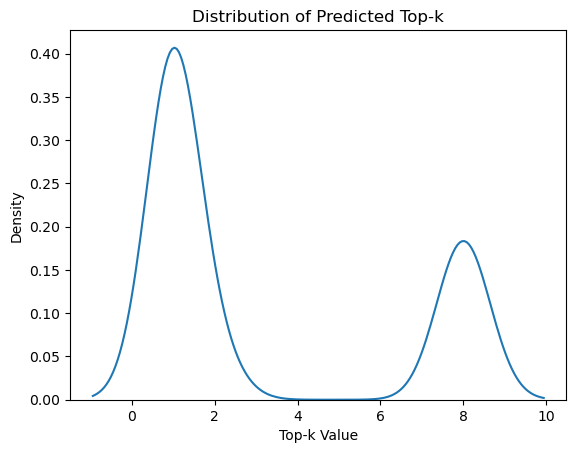

In [ ]:
sns.kdeplot(predicted_topk_distribution, bw_adjust=0.5)
plt.xlabel('Top-k Value')
plt.ylabel('Density')
plt.title('Distribution of Predicted Top-k')
plt.show()

Let's look at questions where the model predicted top-k value 8

In [ ]:
for x, y in zip(predicted_topk_distribution, q_list):
    if x == 8:
        print(y)

Did the survey provide insight into features commonly found to be predictive of abusive content on online platforms?
How much lower is the computational cost of the proposed model?
Is it possible for the DCM module to correct text-relevant content?
What are the opportunities presented by the use of Semantic Web technologies in Machine Translation?
What are the challenges associated with the use of Semantic Web technologies in Machine Translation?
What are the other obstacles to automatic translations which are not mentioned in the abstract?
What architecture does the rest of the multi-task learning setup use?
how are sentences selected prior to making the summary?
Which translation model do they employ?
Which other units of text do they experiment with (apart from BPE and ortographic syllables)?
How many steps of BPE do they experiment with?
How many parameters does their noisy channel model have?
Which BERT-based baselines do they compare to?
What are the propaganda types?
How is the 

Top-k value 1

In [ ]:
for x, y in zip(predicted_topk_distribution, q_list):
    if x == 1:
        print(y)

Is deep learning the state-of-the-art method in automated abuse detection
What datasets were used in this work?
How is abuse defined for the purposes of this research?
Do they use multitask learning?
What language is the model tested on?
What is the state-of-the-art model?
Which real world datasets do they experiment on?
Which other models that incorporate meta information do they compare against?
How do they measure topic quality?
Which data augmentation techniques do they use?
Which dataset do they use for text altering attributes matching to image parts?
Do they report results only on English data?
What are the hyperparameter setting of the MTL model?
How is the selected sharing layer trained?
what state of the art methods are compared to?
what are the performance metrics?
what is the original model they refer to?
Which datasets do they experiment on?
Which language pairs do they evaluate on?
How many layers does the neural network have?
Do they look at various languages?
What datas

Finally, top-k value 2

In [ ]:
for x, y in zip(predicted_topk_distribution, q_list):
    if x == 2:
        print(y)

Is Chinese a pro-drop language?
Is English a pro-drop language?
What is a pseudo language model?
Do the authors examine the real-world distribution of female workers in the country/countries where the gender neutral languages are spoken?
Which of the 12 languages showed the strongest tendency towards male defaults?
How many different sentence constructions are translated in gender neutral languages?


In [ ]:
fdf = pd.DataFrame(columns=["name", "similarity score", "correctness score", "average total llm token count"])
fdf.loc[len(fdf)] = ["Baseline k_1", "0.837208", "2.761905", "991.52381"]
fdf.loc[len(fdf)] = ["Baseline k_5", "0.834273", "2.970238", "4335.761905"]
fdf.loc[len(fdf)] = ["Baseline k_10", "0.826051", "2.994048", "5696.0"]
fdf.loc[len(fdf)] = ["Trained topk", "0.835831", "2.928571", "1857.238095"]
fdf

,name,similarity score,correctness score,average total llm token count
0,Baseline k_1,0.837208,2.761905,991.52381
1,Baseline k_5,0.834273,2.970238,4335.761905
2,Baseline k_10,0.826051,2.994048,5696.0
3,Trained topk,0.835831,2.928571,1857.238095
